In [54]:
from ranx import Run, evaluate, fuse
import numpy as np

In [55]:
import joblib

search_results = joblib.load("../workdir/rerank_ws/search_results.pkl.gz")
# search_results_with_target = joblib.load(
#     "../workdir/rerank_ws/search_results_debug.pkl.gz"
# )

In [56]:
target_dataset_name = "aio_01_test"

In [57]:
search_results = search_results_with_target[target_dataset_name]

In [58]:
len(search_results)

3

In [59]:
search_results[0]["indexes"].shape

(30, 500)

In [60]:
jacket_size = search_results[0]["indexes"].shape[0]
jacket_size

30

In [61]:
runs = []
for search_result in search_results:
    name = search_result["name"]
    print(name)
    scores = search_result["scores"]
    # score が高いほど良い、にするために反転
    scores = np.abs(search_result["scores"] - 1.0)
    indexes = search_result["indexes"]
    qids = search_result["qids"]
    run_dict = {}
    for id, score, index in zip(qids, scores, indexes):
        # id = str(id)
        # score = score.tolist()
        # index = index.tolist()
        index_score_dict = {}
        for s, pid in zip(score, index):
            index_score_dict[str(pid)] = s
        run_dict[id] = index_score_dict
    run = Run(run_dict, name=name)
    runs.append(run)

[debug]intfloat/multilingual-e5-large
[debug]cl-nagoya/sup-simcse-ja-base
[debug]pkshatech/GLuCoSE-base-ja


In [62]:
combined_run = fuse(
    runs=runs,  # A list of Run instances to fuse
    norm="min-max",  # The normalization strategy to apply before fusion
    method="rrf",  # The fusion algorithm to use
)

In [63]:
combined_data = combined_run.to_dict()

In [64]:
len(combined_data)

30

In [65]:
len(combined_data["0"])

0

In [66]:
import json
import os
import re
import time
import urllib.request
from argparse import ArgumentParser
from dataclasses import dataclass
from functools import lru_cache
from pathlib import Path
from time import time

import faiss
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset  # type: ignore
from tqdm import tqdm


WIKIPEDIA_JA_DS = "singletongue/wikipedia-utils"
WIKIPEDIA_JS_DS_NAME = "passages-c400-jawiki-20230403"
WIKIPEDIA_JA_EMB_DS = "hotchpotch/wikipedia-passages-jawiki-embeddings"


def get_wikija_ds(name: str = WIKIPEDIA_JS_DS_NAME):
    ds = load_dataset(path=WIKIPEDIA_JA_DS, name=name, split="train")  # type: ignore
    return ds


# jaqket v1
@dataclass
class JaqketQuestionV1:
    qid: str
    question: str
    answer_entity: str
    label: int
    answer_candidates: list[str]
    original_question: str


print("load wikija datasets")
ds = get_wikija_ds()

jaqket_ds = load_dataset("hotchpotch/jaqket_cc")[target_dataset_name]

load wikija datasets


In [67]:
jaqket_ds = jaqket_ds.select(range(jacket_size))

In [68]:
found_indexes = []
for jaqket in jaqket_ds:
    qid = jaqket["qid"]
    # print("")
    # print(jacket.question)
    # print(jacket.answer_entity)
    found_index = -1
    rank_data = combined_data[qid]
    answers = jaqket["answers"]
    for rank_idx, (k, v) in enumerate(rank_data.items()):
        ds_index = int(k)
        target_data = ds[ds_index]
        join_text = target_data["title"] + target_data["text"]
        for answer in answers:
            if answer in join_text:
                found_index = rank_idx
                break
        if found_index != -1:
            break
    found_indexes.append(found_index)

In [69]:
# index が -1の要素を数える
print(len([i for i in found_indexes if i == -1]))

0


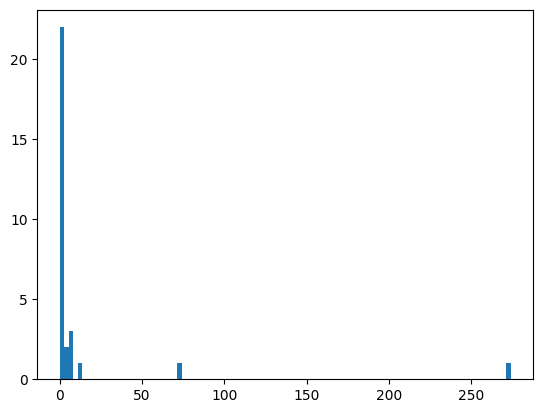

In [70]:
# plt hist
import matplotlib.pyplot as plt

plt.hist(found_indexes, bins=100)
plt.show()

In [71]:
# pd
import pandas as pd

# percentile

pd.Series(found_indexes).describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.85, 0.9])

count     30.000000
mean      12.966667
std       51.029054
min        0.000000
10%        0.000000
25%        0.000000
50%        0.000000
75%        2.750000
85%        6.000000
90%        7.500000
max      274.000000
dtype: float64

In [72]:
# ds の正解ラベルを取得

acc_labels_dict = {}
for jaqket in jaqket_ds:
    qid = jaqket["qid"]
    answers = jaqket["answers"]
    rank_data = combined_data[qid]
    acc_labels = {}
    for rank_idx, (pid, v) in enumerate(rank_data.items()):
        ds_index = int(pid)
        target_data = ds[ds_index]
        join_text = target_data["title"] + " " + target_data["text"]
        for answer in answers:
            if answer in join_text:
                acc_labels[pid] = 1
    acc_labels_dict[qid] = acc_labels

In [123]:
list(runs[0]["QA20CAPR-1004"].items())[0:10]

[('60221', 0.7589395046234131),
 ('5191928', 0.7540078163146973),
 ('60220', 0.7327320575714111),
 ('49522', 0.7222506999969482),
 ('28979', 0.7185060977935791),
 ('221102', 0.7161307334899902),
 ('3931012', 0.7156599760055542),
 ('1953461', 0.7128769159317017),
 ('56160', 0.7128103375434875),
 ('298370', 0.7118793725967407)]

In [124]:
list(runs[1]["QA20CAPR-1004"].items())[0:10]

[('5191928', 0.6499422788619995),
 ('60222', 0.6079652309417725),
 ('60221', 0.6046475768089294),
 ('1459483', 0.5795551538467407),
 ('1767473', 0.5744842290878296),
 ('1912169', 0.5723568797111511),
 ('220168', 0.5538877248764038),
 ('1953461', 0.5487590432167053),
 ('57209', 0.5454387664794922),
 ('2665789', 0.5444352030754089)]

In [74]:
list(acc_labels_dict["QA20CAPR-1002"].items())[0:10]

[('2548662', 1),
 ('4265351', 1),
 ('4265355', 1),
 ('3805776', 1),
 ('4265358', 1),
 ('3805775', 1),
 ('3805777', 1),
 ('4181190', 1),
 ('4265359', 1),
 ('4265360', 1)]

In [75]:
from ranx import evaluate, Qrels

qrels = Qrels(acc_labels_dict)

In [76]:
evaluate(qrels, runs[0], "ndcg@100")

0.41963656167442814

In [77]:
runs[0].name, evaluate(qrels, runs[0], "hit_rate@100")

('[debug]intfloat/multilingual-e5-large', 0.9666666666666667)

In [106]:
from ranx import compare

# Compare different runs and perform statistical tests
report = compare(
    qrels=qrels,
    runs=runs,
    metrics=[
        #         "map@10",
        "map@10",
        "mrr@10",
        "ndcg@10",
        "ndcg@100",
        "hit_rate@1",
        "hit_rate@5",
        "hit_rate@10",
        "hit_rate@20",
        #        "hit_rate@50",
        "hit_rate@100",
        "hit_rate@500",
    ],
    max_p=0.01,  # P-value threshold
)
print(report.to_table())

#    Model                                  MAP@10      MRR@10  NDCG@10    NDCG@100      Hit Rate@1  Hit Rate@5      Hit Rate@10    Hit Rate@20    Hit Rate@100    Hit Rate@500
---  -------------------------------------  --------  --------  ---------  ----------  ------------  ------------  -------------  -------------  --------------  --------------
a    [debug]intfloat/multilingual-e5-large  0.099ᵇ       0.719  0.502ᵇᶜ    0.420ᵇᶜ            0.6    0.933ᵇᶜ               0.933          0.933           0.967           0.967
b    [debug]cl-nagoya/sup-simcse-ja-base    0.049        0.624  0.345      0.269              0.567  0.667                 0.767          0.767           0.833           1
c    [debug]pkshatech/GLuCoSE-base-ja       0.044        0.557  0.315      0.220              0.467  0.667                 0.767          0.8             0.933           1


In [127]:
from ranx import fuse, evaluate, optimize_fusion


# Optimize a given fusion method
best_params = optimize_fusion(
    qrels=qrels,
    runs=runs,
    norm="min-max",  # Default value
    method="wsum",  # Alias for Weighted Sum
    metric="ndcg@100",  # Metric we want to maximize
)

combined_run = fuse(
    runs=runs,
    norm="min-max",  # Default value
    method="wsum",  # Alias for Weighted Sum
    params=best_params,
)

print(combined_run.name, evaluate(qrels, combined_run, "ndcg@100"))

Output()

weighted_sum 0.43931019882427574


In [128]:
# combined_run.keys()["0"]
""

''

In [129]:
print(combined_run.name, evaluate(qrels, combined_run, "ndcg@100"))

weighted_sum 0.9666666666666667


In [130]:
combined_data = combined_run.to_dict()

In [131]:
combined_keys = list(combined_data.keys())[0:10]

In [132]:
jaqket_dict = {}
for jaqket in jaqket_ds:
    qid = jaqket["qid"]
    jaqket_dict[qid] = jaqket

In [133]:
for key in combined_keys:
    data = combined_data[key]
    jaqket = jaqket_dict[key]
    question = jaqket["question"]
    answers = jaqket["answers"]
    print("-------")
    print(question)
    print(answers)
    for k, v in list(data.items())[0:3]:
        d = ds[int(k)]
        title = d["title"]
        text = title + " " + d["text"]
        for answer in answers:
            if answer in text:
                print(text)

-------
「課長」こと有野晋哉が様々なレトロゲームをクリアしていくという内容の、CS放送の人気番組は何でしょう?
['ゲームセンターCX']
ゲームセンターCX 有野の挑戦 「有野の挑戦」は、『ゲームセンターCX』におけるメイン企画コーナーである。毎回、1985年から2000年のテレビゲーム(レトロゲーム)をクリアするために、有野課長(有野晋哉)が悪戦苦闘しながらプレイし、アシスタントディレクター(AD)ら番組スタッフ達と協力しながらエンディングを目指す、ドキュメンタリー形式のバラエティー企画となっている。第22シーズンまでの通算成績。215勝73敗3分2持ち越し1保留。総挑戦時間3125時間47分(生放送・DVD・ニンテンドー含む)、平均挑戦時間約10時間37分。なお、第22シーズン終了時点における連勝の最多記録は、第19、20シーズン跨ぎでの11連勝(1シーズン単位では第20シーズンでの10連勝)。最多連敗は第4、6、17シーズンでの4連敗となっている。ただし1998年に発売したソフトは第276回時点で、一度も挑戦失敗していない。
ゲームセンターCX お笑いコンビ「よゐこ」の有野晋哉が扮する当番組のメインパーソナリティ。架空の企業である「株式会社ゲームセンターCX興業」の社員で、番組開始時は主任で始まり、その後課長代理を経て、現在は課長という番組設定である(海外版はシリーズ通して「KACHO」で統一)。課長の主な仕事は、助っ人のアシスタントディレクターらと協力しながら「テレビゲーム」をプレイして、エンディングを見ることである(場合によってはお題クリアのみもある)。ゲームの腕は初心者に毛が生えた程度であり、テクニック不足や凡ミスも多い。特に瞬発力を要するシューティング・格闘ACTのようなジャンルは鬼門のようである。ただ、パズル系のような頭を使うものは得意のようで先の先を読んだプレイや閃きが冴える場面が多いが、有野が得意とするパズルのジャンル内でも落ちもの系パズルや反射神経を要するものは苦手の様子(『ぷよぷよ』・『コラムス』など)。
ゲームセンターCX 昔懐かしいコンピュータゲーム(レトロゲーム)に焦点を当て、毎回異なるゲームソフトにお笑いタレントのよゐこの有野晋哉が挑戦し、13時間前後の収録時間内に完全クリアしてエンディング画面を目指す「有野の挑戦」をメイン